<a href="https://colab.research.google.com/github/natrask/ENM1050/blob/main/Code%20examples/Lecture_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install necessary libraries:** Colab doesn't come with torchdiffeq by default, so we will pip install here

In [1]:
!pip install torchdiffeq

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchdiffeq import odeint
import torch.nn as nn
import torch.optim as optim

# Introducing Neural ODEs #

## Example 1 - Skydiver ##

We're going to revisit the exercise we did when we learned about how to use odeint to predict the terminal velocity of a skydiver. Remember way back in Lecture 8, we derived a differential equation describing the dynamics of a skydiver:

$m \ddot{y} = -m g + \frac12 \rho \dot{y}^2 A C_d$, where
  * $m$ is the mass of the skydiver
  * $y,\dot{y}$, and $\ddot{y}$ are the position, velocity, and acceleration of the skydiver, respectively.
  * $\rho$ is the density of the air
  * $A$ is the [projected area](https://en.wikipedia.org/wiki/Projected_area) area of the diver
  * $C_d$ is a coefficient of friction

In that lecture, after deriving that model by hand, we solved the equation using odeint. We also compared whether we would be able to recover the *terminal velocity* from our simulation, by setting the acceleration to zero on the left hand side ($\ddot{y}=0$), and solving for $\dot{y}$ to get the steady state velocity:
$$ \dot{y}_{ss} = \sqrt{\frac{2 m g}{\rho A C_d}}$$

What would we do if we weren't able to derive a model for the RHS? We can start by saying that $F = ma$, but maybe the forces are either too complicated to derive a model for (e.g. high-energy physics, explosions, climate, space physics), or we might just not have the background or training to derive a model (maybe your boss is asking you to design a hydraulic pump, but you slept through that class in college).

What we can do instead is slap a sensor on a skydiver and do an experiment (maybe a few experiments on different skydivers) where we track their altitude vs time after they jump out of a plane. We can assume that Newton's law holds, but that a **black box** function defines how to calculate the forces.
$$m \ddot{y} = F(y,\dot{y},\theta)$$

In the black box function $F$, I've assumed that the forces depend on a few things: the altitude ($y$), the velocity ($\dot{y}$), and a list of parameters called $\theta$. If we look at the hand-derived model, we can see that a whole bunch of "extra" things effect the force calculation: mass, gravity, density of air, projected area, and coefficient of friction. In this example, $\theta = \left\{m,g,\rho,A,C_d\right\}$.

This is where neural networks come in - because they can approximate an arbitrary function, we can build a neural network that takes $y$,$\dot{y}$, and any hypothesized $\theta$ as an input and predict the right hand side of an ODE. A neural ODE solves the ode the exact same way that odeint did in scipy, but keeps track of all of the intermediate values so that it can perform automatic differentiation, comparing *the entire solution* to the desired solution and using automatic differentiation to modify the right hand side.

We will work through this skydiver example to "reverse-engineer" the RHS of the ode.


### Step 1 - Load data into Pytorch ###

In here, I'm just copying and pasting the odeint simulation that we ran before. Remember that we gathered coefficients together to make it simpler to code
$$\ddot{y} = \alpha + \beta \dot{y}$$
and then we re-wrote as a system of first-order ODEs
$$\frac{d}{dt} \mathbf{y} =  \begin{pmatrix} \dot{y}_1 \\ \dot{y}_2 \end{pmatrix} =  \begin{pmatrix} y_2 \\ \alpha + \beta y_1^2\end{pmatrix} = F(\mathbf{y}) $$

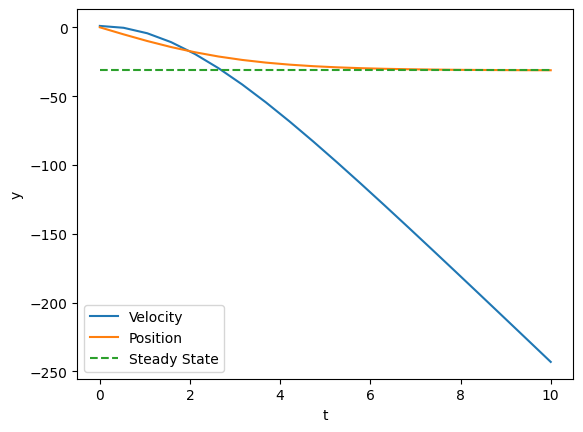

In [3]:
import scipy

# In the old exercise, remember that we gathered up all of the parameters into these two coefficients alpha and beta
alpha = -9.81
beta = 0.01

# We define the right hand side ode the ode. Remember that we
def dydt(y, t):
    dy1dt = y[1]
    dy2dt = alpha + beta * y[1]**2
    return [dy1dt, dy2dt]

y0 = [1.0, 0.0]
t = np.linspace(0, 10, 20)
sol = scipy.integrate.odeint(dydt, y0, t)

plt.plot(t, sol[:, 0], label='Velocity')
plt.plot(t, sol[:, 1], label='Position')
steady_state = -np.sqrt(-alpha / beta)
plt.plot(t, steady_state * np.ones(len(t)), '--', label='Steady State')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()

Next we will fold this into pytorch tensors so that we can use this as targets for our model. As usual, we need to rescale everything to be between 0 and 1.

In [4]:
tscale = t.max()-t.min()
yscale = sol.max()-sol.min()

t_torch = torch.tensor(t/tscale, requires_grad=False, dtype=torch.float32)
target_torch = torch.tensor(sol/yscale, requires_grad=False, dtype=torch.float32)

### Step 2 - Build model ###

Next we will build up our model. We will also need to build up a class to define the neural ode model. This is because we are nesting two models inside of each other. The first one (ODEFunc) explains how to take a single timestep. The Neural ODE model (NeuralODE) then takes multiple timesteps, calling ODEFunc each time.

The things we need to do here are:
* Pick the right size input and output - for us we have two inputs ($y_1,y_2$) and two outputs ($\dot{y}_1,\dot{y}_2$).
* Pick how big of a network - that is specified in the hidden_size and hidden_layers

In [5]:
# Define the ODE function
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        input_size = 2
        hidden_size = 40
        hidden_layers = 3
        output_size = 2

        # This is a complicated function - it will use lists to build as many hidden layers as we asked for
        # For an explanation - ask Gemini "explain how self.net is constructed"
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            *[nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.Tanh()) for _ in range(hidden_layers)],
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, t, y):
        return self.net(y)

# Define the Neural ODE model
class NeuralODE(nn.Module):
    def __init__(self, ode_func):
        super(NeuralODE, self).__init__()
        self.ode_func = ode_func

    def forward(self, y0, t):
        return odeint(self.ode_func, y0, t)

### Step 3 - Initialize model and optimizer ###

Next we will initialize the model - the new things here are:
* Need to initialize both the RHS model and the ODE solver model
* Need to specify the initial conditions and the times where we want the solutions
* The rest are the same as usual

In [6]:
# Create the ODE RHS function and Neural ODE model that solves dydt = f(y)
ode_func = ODEFunc()
neural_ode = NeuralODE(ode_func)

# Define initial condition
y0 = target_torch[0,:]

# Define a simple loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(neural_ode.parameters(), lr=0.01)

### Step 4 - Train model ###

Now we train the model - this is the same as usual - but when we evaluate the model at each step now we need to specify the initial condition. Otherwise business as usual!

In [7]:
# Training loop
for epoch in range(500):
    optimizer.zero_grad()
    y_pred = neural_ode(y0, t_torch)
    loss = criterion(y_pred, target_torch)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.20279140770435333
Epoch 50, Loss: 0.0024909263011068106
Epoch 100, Loss: 0.0026057311333715916
Epoch 150, Loss: 0.00011292046110611409
Epoch 200, Loss: 4.115398769499734e-05
Epoch 250, Loss: 1.7832386220106855e-05
Epoch 300, Loss: 9.602425052435137e-06
Epoch 350, Loss: 6.067541107768193e-06
Epoch 400, Loss: 4.256490683474112e-06
Epoch 450, Loss: 3.3320932288916083e-06


### Step 5 - Visualize results ###

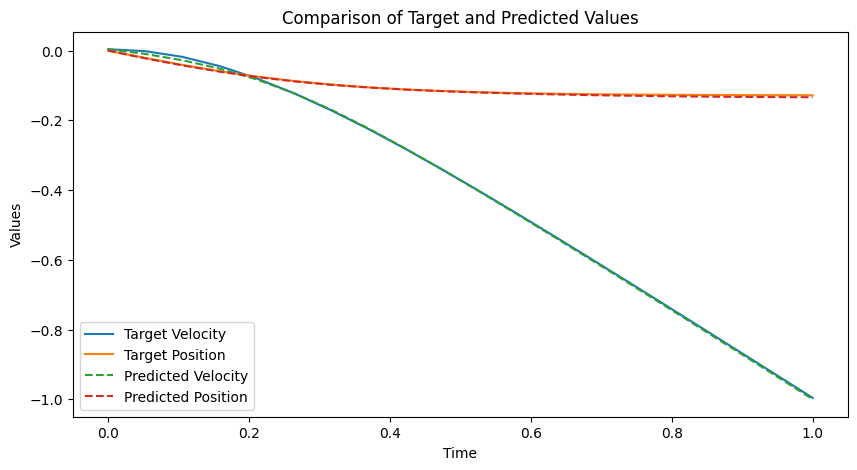

In [9]:
# Evaluate the trained model
y_pred = neural_ode(y0, t_torch).detach().numpy()

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t_torch.numpy(), target_torch[:, 0].numpy(), label='Target Velocity')
plt.plot(t_torch.numpy(), target_torch[:, 1].numpy(), label='Target Position')
plt.plot(t_torch.numpy(), y_pred[:, 0], '--', label='Predicted Velocity')
plt.plot(t_torch.numpy(), y_pred[:, 1], '--', label='Predicted Position')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Comparison of Target and Predicted Values')
plt.show()

## Example 2 - A peek under the hood ##

What exactly is the neuralode class doing? In the next example I'm going to show that in the same way that we implemented our own explicit Euler method in Lecture 8, we can do the same thing here. We will repeat Example 1, but now I will show what it would look like if we implemented all of this from scratch outselves.

### Step 1 - Load data into Pytorch ###

Nothing needed here - we already loaded out data into memory in the last example.

### Step 2 - Build model ###

Instead of using the NeuralODE class - we could have made our own class that uses explicit Euler. In practice we would never do things in this way - the point of this example is to help you understand what is happening "behind the scenes".

In [10]:
class OurOwnNeuralODE(nn.Module):
    def __init__(self):
        super(OurOwnNeuralODE, self).__init__()
        self.input_size = 2
        self.hidden_size = 40
        self.hidden_layers = 3
        self.output_size = 2

        # We will take the exact
        self.net = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.Tanh(),
            *[nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size), nn.Tanh()) for _ in range(self.hidden_layers)],
            nn.Linear(self.hidden_size, self.output_size)
        )


    def forward(self, y0, dt, Nsteps):
        solution = [y0]
        y = y0
        for i in range(Nsteps):
            y = y + dt * self.net(y)
            solution.append(y)
        return torch.stack(solution) # stack takes a list of tensors and turns them into a single tensor

### Step 3 - Initialize model and optimizer ###

In [11]:
# Create the ODE RHS function and Neural ODE model that solves dydt = f(y)
node_model = OurOwnNeuralODE()

# Define initial condition, timestep size, and number of steps
y0 = target_torch[0,:]
dt = t[1]-t[0]
Nsteps = len(t)-1

# Define a simple loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(node_model.parameters(), lr=0.01)

### Step 4 - Train model ###

In [12]:
# Training loop
for epoch in range(500):
    optimizer.zero_grad()
    y_pred = node_model(y0, dt, Nsteps)
    loss = criterion(y_pred, target_torch)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.45588549971580505
Epoch 50, Loss: 0.0011591727379709482
Epoch 100, Loss: 0.0007557440549135208
Epoch 150, Loss: 0.0003265214618295431
Epoch 200, Loss: 0.00028958916664123535
Epoch 250, Loss: 0.0002501659619156271
Epoch 300, Loss: 0.00020945475262124091
Epoch 350, Loss: 0.00016871442494448274
Epoch 400, Loss: 0.00012839931878261268
Epoch 450, Loss: 0.00030960896401666105


### Step 5 - Visualize results ###

Just copying and pasting the same plotting code from Example 1.

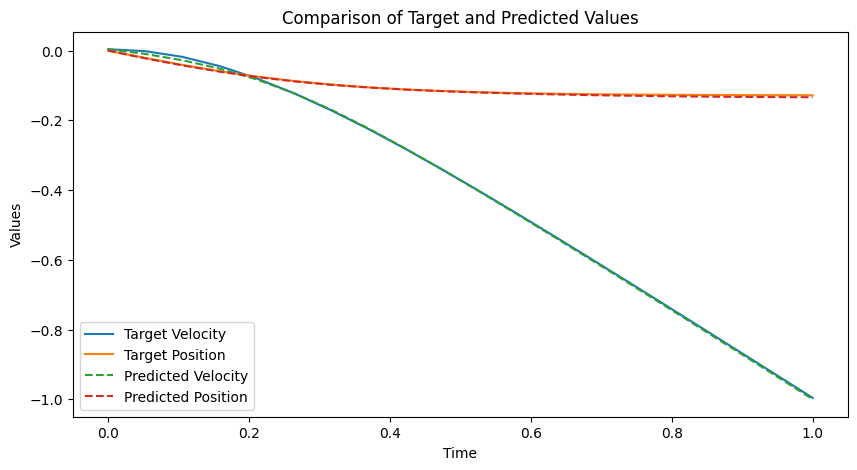

In [13]:
# Evaluate the trained model
y_pred = neural_ode(y0, t_torch).detach().numpy()

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t_torch.numpy(), target_torch[:, 0].numpy(), label='Target Velocity')
plt.plot(t_torch.numpy(), target_torch[:, 1].numpy(), label='Target Position')
plt.plot(t_torch.numpy(), y_pred[:, 0], '--', label='Predicted Velocity')
plt.plot(t_torch.numpy(), y_pred[:, 1], '--', label='Predicted Position')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Comparison of Target and Predicted Values')
plt.show()

## Example 3 - Revisiting HW4 ##

Finally - let's revisit our predator prey model. We saw in the last homework that the fit was qualitatively interesting. It showed that there are patterns of rock/paper/scissors/rock/paper/scissors/..., but it couldn't do a good job matching the actual data. Today we are going to see if we could get anything better using a neural ODE to fit the model, instead of guessing the model form ourselves.

### Step 1 - Load data into Pytorch ###

This is copied straight out of the solution to the last homework - loading in the smoothed data into pytorch tensors.

In [43]:
import pickle
import os
# Import data in the form of pkl files from the google drive
from google.colab import drive
drive.mount('/content/drive')

#enter the path to where you stored your data
datadirectory = '/content/drive/My Drive/ENM1050/data_fromrockpaperscissors/'

#loop over all files in the directory ending with .pkl and add them to datalist
dataList = []
for filename in os.listdir(datadirectory):
    if filename.endswith('.pkl'):
        with open(os.path.join(datadirectory, filename), 'rb') as file:
            data = pickle.load(file)
            # Process the loaded data here
            print(f"Loaded data from {filename}")

            # Do some processing to make them all the same size
            data = np.array(data)[:5000,:]
            dataList.append(data)

# Smooth the data and store it in this list
smoothedDataList = []
# Define a moving average filter function
def moving_average(data, window_size=250):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plot data on each subplot
for idx, sim in enumerate(dataList[:10]):
    smoothed_sim = np.apply_along_axis(moving_average, 0, sim)  # Apply smoothing filter
    smoothedDataList.append(smoothed_sim)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded data from populations_experiment-02.pkl
Loaded data from populations_experiment-09.pkl
Loaded data from populations_experiment-01.pkl
Loaded data from populations_experiment-03.pkl
Loaded data from populations_experiment-04.pkl
Loaded data from populations_experiment-07.pkl
Loaded data from populations_experiment-06.pkl
Loaded data from populations_experiment-10.pkl
Loaded data from populations_experiment-08.pkl
Loaded data from populations_experiment-05.pkl


Now that we've loaded in the smoothed data, we will put the data into pytorch tensors. We note that the populations are already between 0 and 1 so no scaling is needed, but we will pick a time scaling so that the timesteps are between 0 and 1.

In [75]:
data_np = np.array(smoothedDataList)
data_scale = 1.0 #data_np.max()-data_np.min()
data_torch = torch.tensor(data_np[:,::25,:]/data_scale, dtype=torch.float32, requires_grad=False) #only keep every 25 timesteps

time_np = np.linspace(0, 1.0, data_np.shape[1])
time_torch = torch.tensor(time_np[::25], dtype=torch.float32,requires_grad=False)

### Step 2 - Build model ###

In [76]:
# Define the ODE function
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        input_size = 3
        hidden_size = 40
        hidden_layers = 3
        output_size = 3

        # Define the initial and final layers
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)

        # Define the hidden layers with residual connections
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_size, hidden_size) for _ in range(hidden_layers)]
        )
        self.activation = nn.Tanh()

    def forward(self, t, y):
        # Initial layer
        y = self.activation(self.input_layer(y))

        # Hidden layers with residual connections
        for layer in self.hidden_layers:
            y = y + self.activation(layer(y))

        # Output layer
        return self.output_layer(y)

# Define the Neural ODE model with adaptive timestepping
class NeuralODE(nn.Module):
    def __init__(self, ode_func, atol=1e-4, rtol=1e-3):
        super(NeuralODE, self).__init__()
        self.ode_func = ode_func
        self.atol = atol
        self.rtol = rtol

    def forward(self, y0, t):
        return odeint(self.ode_func, y0, t, atol=self.atol, rtol=self.rtol)


### Step 3 - Initialize model and optimizer ###

In [83]:
# Create the ODE RHS function and Neural ODE model that solves dydt = f(y)
ode_func = ODEFunc()
neural_ode = NeuralODE(ode_func, atol=1e-4, rtol=1e-3) # Adjust tolerances as needed

# Define a simple loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(neural_ode.parameters(), lr=0.01)

### Step 4 - Train model ###

To train the model, we can either load in an entire trajectory at a time:

In [84]:
# Training loop
for epoch in range(2000):
    # grab random experiment from dataset
    Nexperiments = data_torch.shape[0]
    randExp = np.random.randint(0,Nexperiments)
    target = data_torch[randExp,:,:]
    y0 = data_torch[randExp,0,:]

    optimizer.zero_grad()
    y_pred = neural_ode(y0,time_torch)
    loss = criterion(y_pred, target)
    loss.backward()
    optimizer.step()
    if epoch % 25 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.11311119049787521
Epoch 25, Loss: 0.13248133659362793
Epoch 50, Loss: 0.14944663643836975
Epoch 75, Loss: 0.16974833607673645
Epoch 100, Loss: 0.03272349014878273
Epoch 125, Loss: 0.036853667348623276
Epoch 150, Loss: 0.046522218734025955
Epoch 175, Loss: 0.1330404281616211
Epoch 200, Loss: 0.1320248246192932
Epoch 225, Loss: 0.03487541526556015
Epoch 250, Loss: 0.15793640911579132
Epoch 275, Loss: 0.028783680871129036
Epoch 300, Loss: 0.1773555874824524
Epoch 325, Loss: 0.03382056578993797
Epoch 350, Loss: 0.030086364597082138
Epoch 375, Loss: 0.040696363896131516
Epoch 400, Loss: 0.039188601076602936
Epoch 425, Loss: 0.14971554279327393


KeyboardInterrupt: 

Or "minibatch" by grabbing short random subsets of the trajectories - this lets us significantly speed things up because we don't need to store every timestep at once.

In [ ]:
# Training loop
for epoch in range(20000):
    # grab random experiment from dataset
    Nexperiments = data_torch.shape[0]
    randExp = np.random.randint(0,Nexperiments)
    target = data_torch[randExp,:,:]

    # grab a short trajectory from experiments at random
    batchsize = 5
    randStart = np.random.randint(0,data_torch.shape[1]-batchsize)
    short_time = torch.tensor(time_np[randStart:randStart+batchsize], dtype=torch.float32,requires_grad=False)
    y0 = data_torch[randExp,randStart,:]
    short_target = data_torch[randExp,randStart:randStart+batchsize,:]

    optimizer.zero_grad()
    y_pred = neural_ode(y0,time_torch)
    loss = criterion(y_pred, target)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.15632370114326477
Epoch 100, Loss: 0.03875456005334854
Epoch 200, Loss: 0.034049514681100845
Epoch 300, Loss: 0.033868346363306046
Epoch 400, Loss: 0.029488712549209595
Epoch 500, Loss: 0.23765414953231812
Epoch 600, Loss: 0.032711733132600784
Epoch 700, Loss: 0.09814845025539398
Epoch 800, Loss: 0.03448760136961937
Epoch 900, Loss: 0.16147345304489136
Epoch 1000, Loss: 0.12081313878297806
Epoch 1100, Loss: 0.1234581395983696
Epoch 1200, Loss: 0.042956627905368805
Epoch 1300, Loss: 0.1553284078836441
Epoch 1400, Loss: 0.037270501255989075
Epoch 1500, Loss: 0.12601864337921143
Epoch 1600, Loss: 0.02776360884308815
Epoch 1700, Loss: 0.03510347381234169
Epoch 1800, Loss: 0.02468378283083439
Epoch 1900, Loss: 0.09559189528226852
Epoch 2000, Loss: 0.16885192692279816
Epoch 2100, Loss: 0.03669975325465202
Epoch 2200, Loss: 0.0358438715338707


## Step 5 - Visualize ##

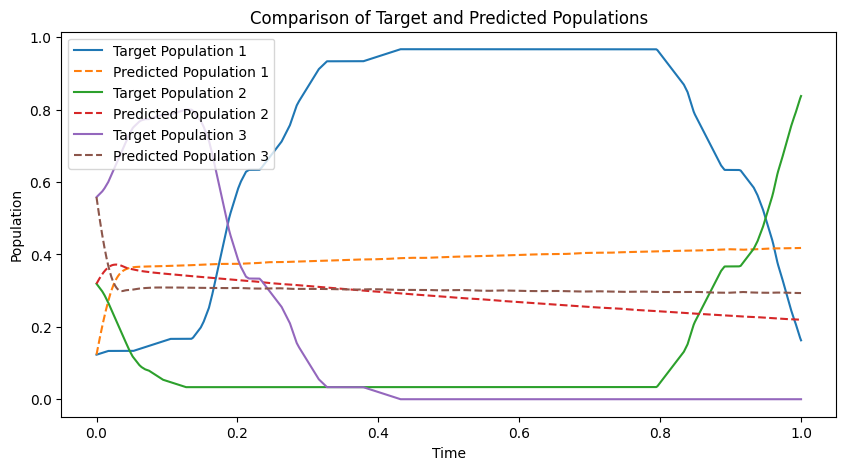

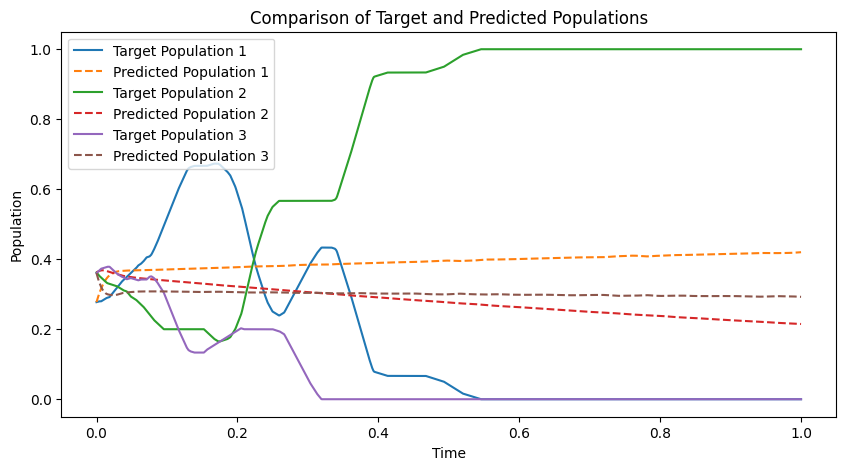

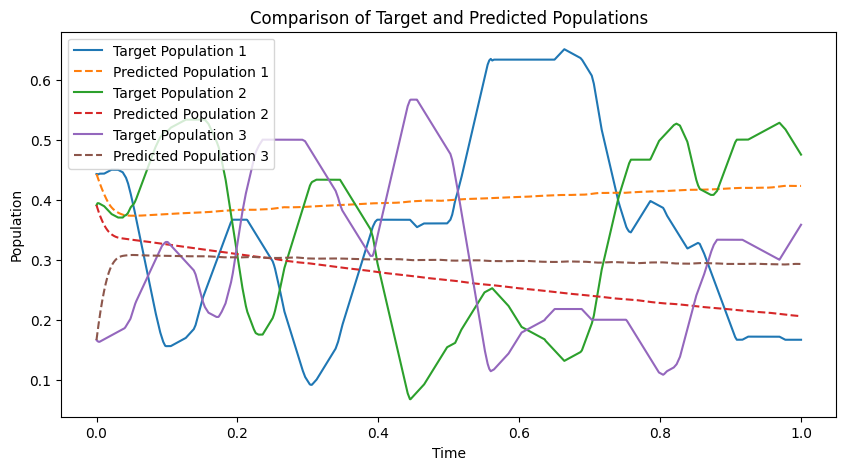

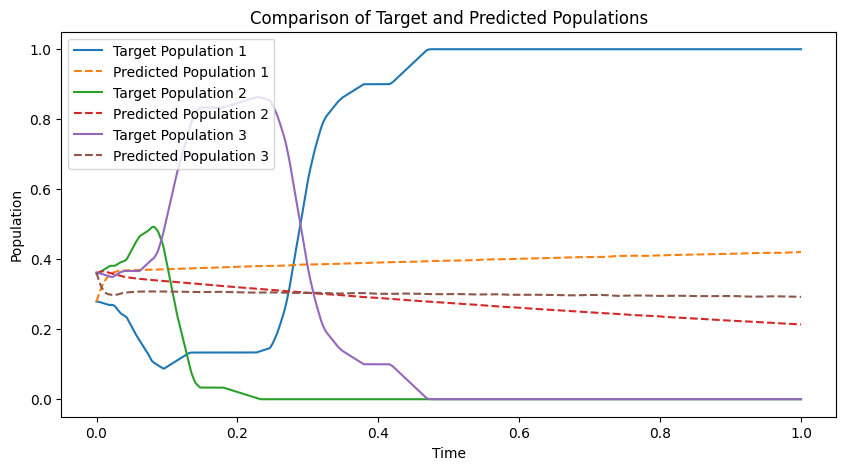

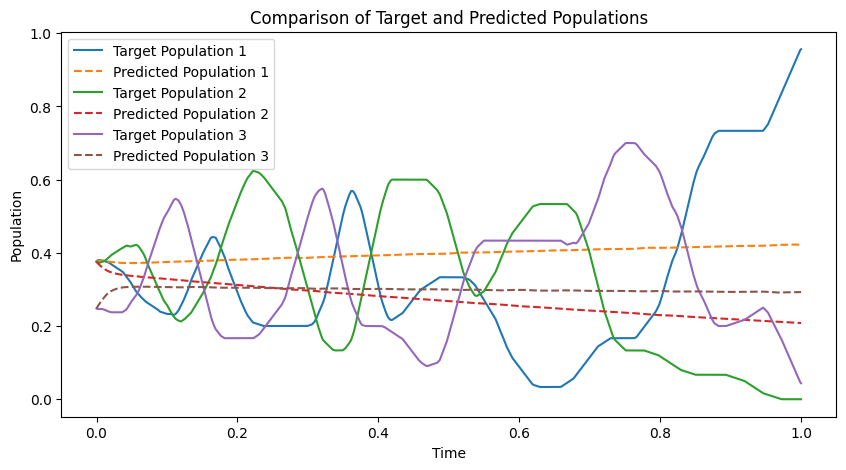

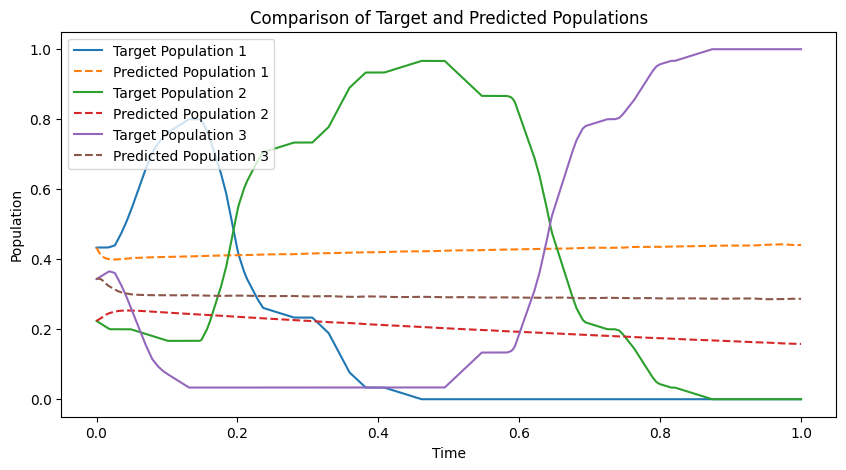

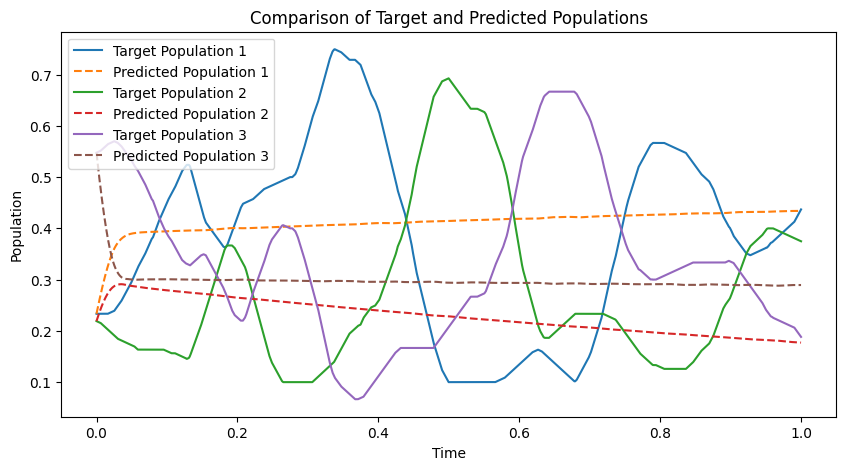

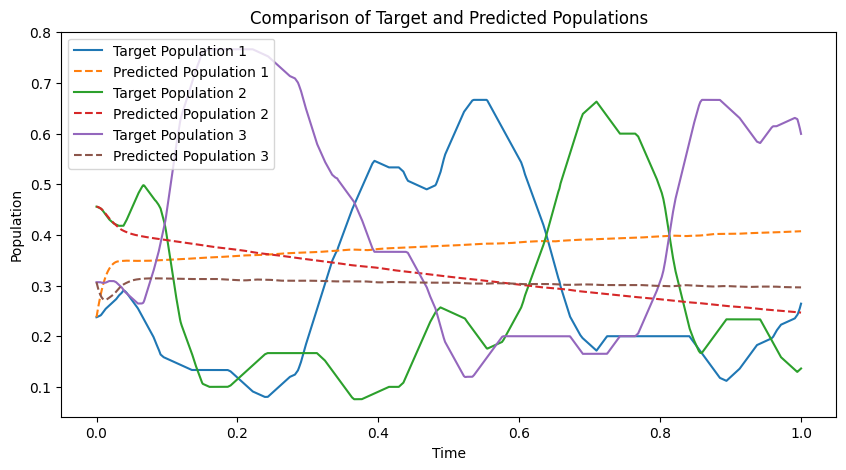

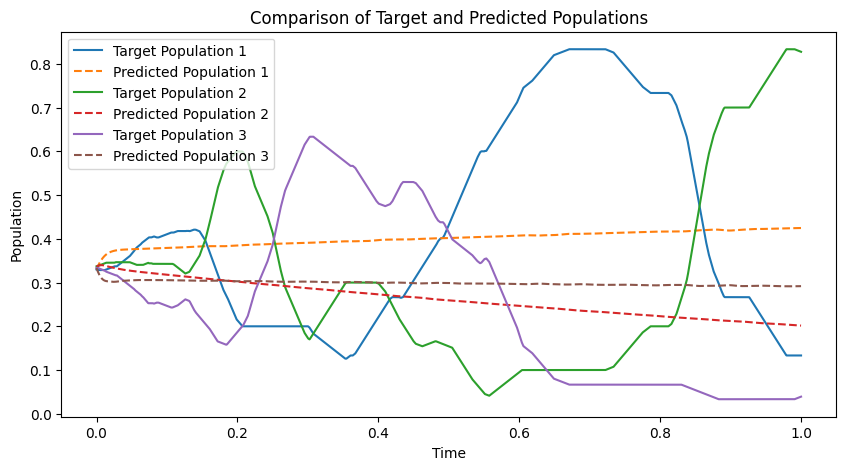

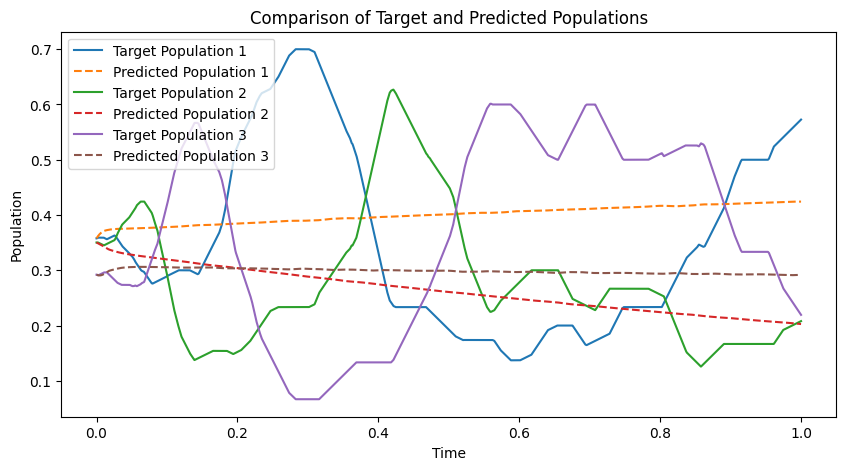

In [69]:
# Evaluate the trained model on a random experiment
Nexperiments = data_torch.shape[0]
for expnumber in range(Nexperiments):
  y0 = data_torch[expnumber, 0, :]
  target = data_torch[expnumber, :, :]
  y_pred = neural_ode(y0, time_torch).detach().numpy()

  # Plot the results for each population
  plt.figure(figsize=(10, 5))
  for i in range(3):
    plt.plot(time_torch.numpy(), target[:, i], label=f'Target Population {i+1}')
    plt.plot(time_torch.numpy(), y_pred[:, i], '--', label=f'Predicted Population {i+1}')

  plt.xlabel('Time')
  plt.ylabel('Population')
  plt.legend()
  plt.title('Comparison of Target and Predicted Populations')
  plt.show()